# Advanced Lane Finding Project

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ImageProcessing.process as proc
from ImageProcessing.pipeline import *
import pickle
import imp

%matplotlib inline

import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

Use 9x6 grid to find image points.

In [2]:
nx, ny = 9, 6

Create the object points.

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Find the 2D image points of the chessboard

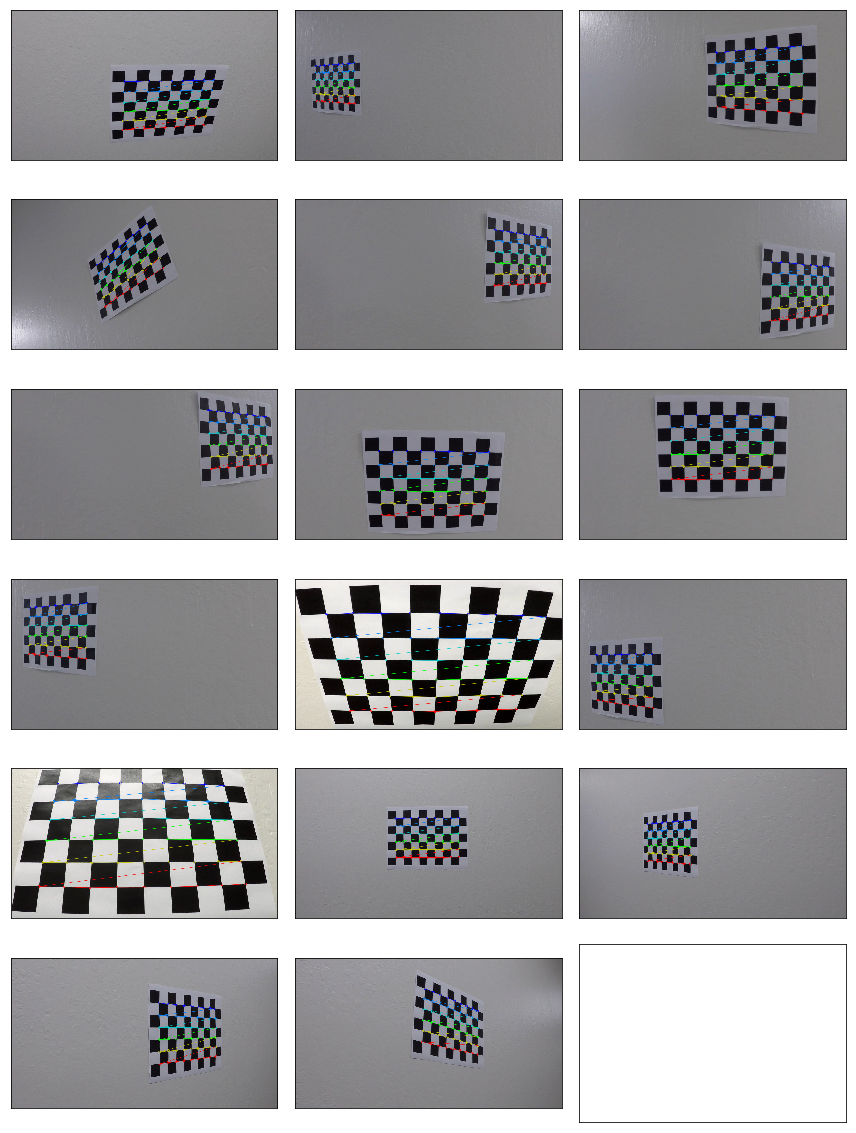

In [4]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12,16), subplot_kw={'xticks': [], 'yticks': []})

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = sorted(glob.glob('camera_cal/calibration*.jpg'))

# Step through the list and search for chessboard corners
count = 0
for fname in images[1:]:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        ax[count//3][count%3].imshow(img)
        
        count += 1
plt.tight_layout()

### Calibrate and Undistort a Test Image

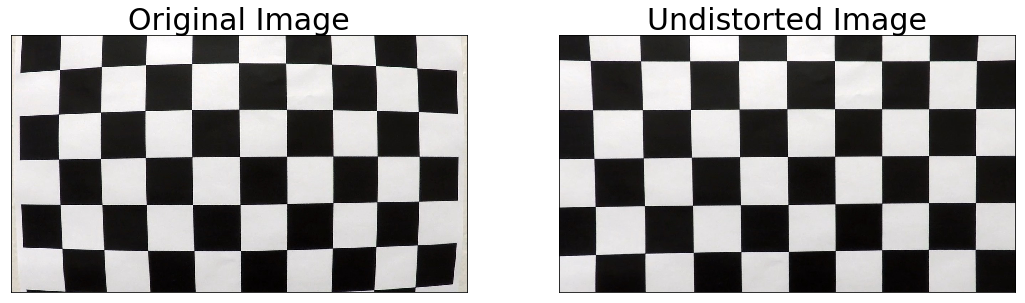

In [5]:
img = mpimg.imread(images[0])

# Do camera calibration given object points and image points
mtx, dist = proc.calibrate(img, objpoints, imgpoints)
dst = proc.undist(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6), 
                             subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30);

In [6]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "ImageProcessing/dist_pickle.p", "wb" ) )

## Pipeline (Image)

### Undistort Image

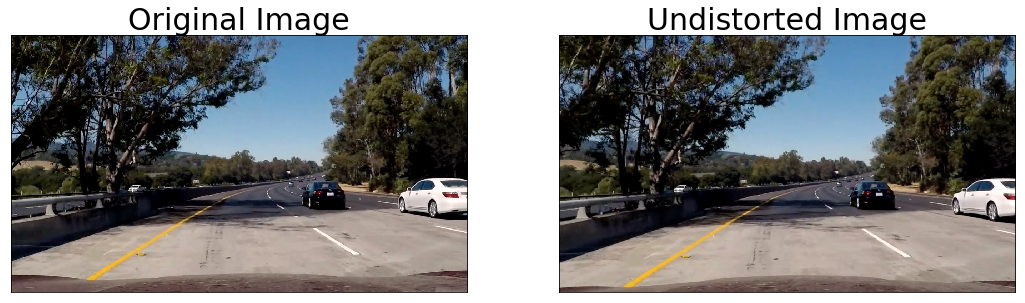

In [7]:
img = mpimg.imread('test_images/test5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6), 
                             subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(proc.undist(img, mtx, dist))
ax2.set_title('Undistorted Image', fontsize=30);

### Creating Thresholded Image

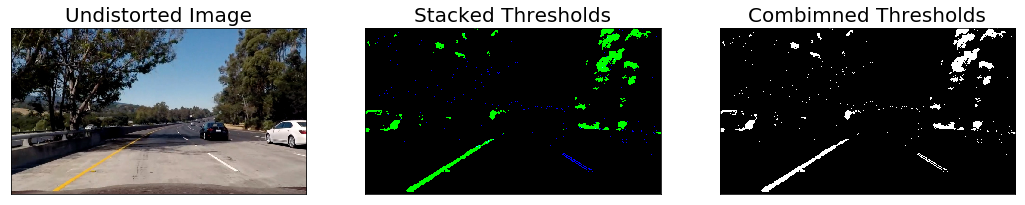

In [13]:
test_img = mpimg.imread('test_images/test5.jpg')
test_img = proc.undist(test_img, mtx, dist)

fig, ax = plt.subplots(1, 3, figsize=(18,4), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(test_img)
ax[0].set_title('Undistorted Image', fontsize=20)

imp.reload(proc)

combined, color_binary = proc.thresholding(test_img, {}, {'b_chn_thresh': (145, 255)})

ax[1].imshow(color_binary)
ax[1].set_title('Stacked Thresholds', fontsize=20)

ax[2].imshow(combined, cmap='gray')
ax[2].set_title('Combimned Thresholds', fontsize=20);

### Perspective Transform

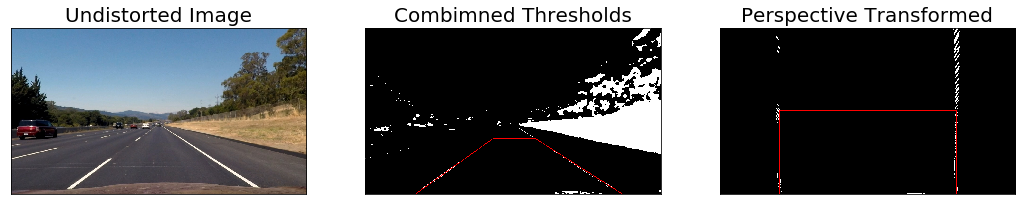

In [9]:
test_img = mpimg.imread('test_images/straight_lines2.jpg')
test_img = proc.undist(test_img, mtx, dist)

imp.reload(proc)

fig, ax = plt.subplots(1, 3, figsize=(18,4), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(test_img)
ax[0].set_title('Undistorted Image', fontsize=20)

h, w = test_img.shape[:2]

SRC = np.array([[1.7 * w // 10, h], [8.7 * w // 10, h], [5.75 * w // 10, h - h // 3], 
                    [4.33 * w // 10, h - h // 3]])
DST = np.array([[2 * w // 10, h], [8 * w // 10, h], [8 * w // 10, h // 2], 
                    [2 * w // 10, h // 2]])

combined, color_binary = proc.thresholding(test_img, {}, {'b_chn_thresh': (145, 255)})
img = np.dstack((combined, combined, combined)) * 255
cv2.polylines(img, [np.r_[SRC, SRC[[0]]].astype(np.int32).reshape((-1,1,2))], 
              False, (255,0,0), thickness=2)
ax[1].imshow(img)
ax[1].set_title('Combimned Thresholds', fontsize=20)

warped, M, Minv = proc.perspective_transform(combined, SRC, DST)
img = np.dstack((warped, warped, warped)) * 255
cv2.rectangle(img, tuple(DST[0]), tuple(DST[2]), (255,0,0), thickness=3)

ax[2].imshow(img)
ax[2].set_title('Perspective Transformed', fontsize=20);

### Fitting a Quadratic Function

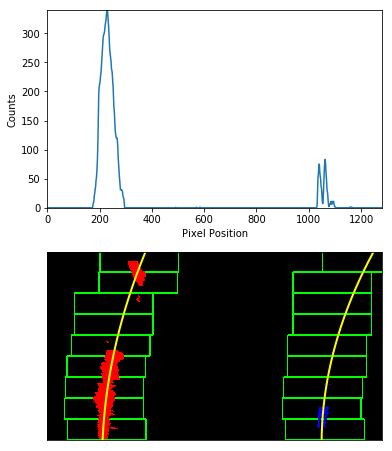

In [14]:
return_vars, outimg = proc.scan_find_lane(warped, margin=150, plot=True)

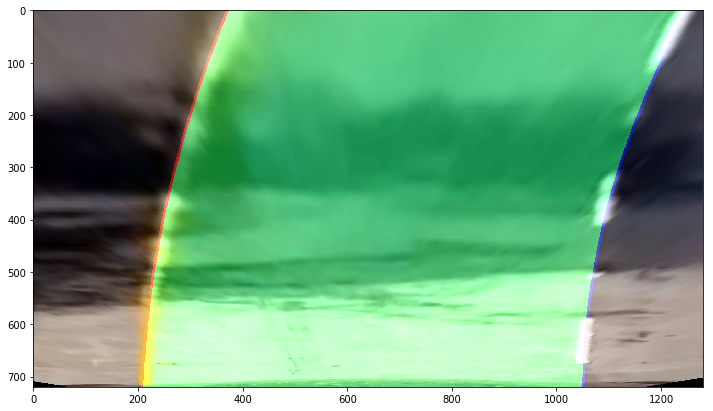

In [15]:
imp.reload(proc)
plt.imshow(proc.drawPoly(cv2.warpPerspective(test_img, M, test_img.shape[1::-1], flags=cv2.INTER_LINEAR), 
              return_vars['left_fit_x'], return_vars['fit_y'], return_vars['right_fit_x'], return_vars['fit_y']))

### Full Pipeline

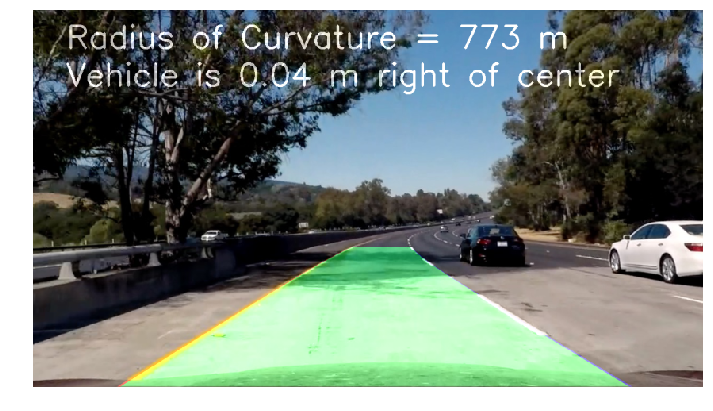

In [12]:
img = mpimg.imread('test_images/test5.jpg')
plt.rcParams['figure.figsize'] = (12, 8)
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
    pass
out = pipeline(img)
plt.imshow(out)
plt.axis('off')
plt.show()

## Pipeline (Video)

### Project Video

In [4]:
project_video = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
clip1_out = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_out.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [14:41<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 37min 2s, sys: 2min 7s, total: 39min 10s
Wall time: 14min 41s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))

In [3]:
challenge_video = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
clip2_out = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip2_out.write_videofile(challenge_video, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [05:20<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 14min 1s, sys: 42.2 s, total: 14min 44s
Wall time: 5min 21s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video))